# using acs_regional_stats to calculate an area-averaged time series
This notebook shows an example of using acs_regional_stats to calculate an area-averaged time series.

1. calculate regional averages.
2. then visualise time series for a selected region

I have tested this with a 14-core CPU and 63 GB of memory. Most will work with fewer resources, but the BARPA example is very large.




In [1]:
# navigate to your directory with "plotting maps" 

In [1]:
cd /g/data/mn51/users/gt3409/plotting_maps/

/g/data/mn51/users/gt3409/plotting_maps


In [2]:
# import needed packages
from acs_area_statistics import acs_regional_stats, get_regions
import xarray as xr
import geopandas as gpd
import regionmask
import cartopy.crs as ccrs
from glob import glob
import numpy as np
import seaborn as sns

In [3]:
import matplotlib.pyplot as plt

In [4]:
# mask
# select masks that define the regions you want to work with
# this shows fractional mask
mask_ncra = xr.open_dataset("/g/data/ia39/aus-ref-clim-data-nci/shapefiles/masks/AGCD-05i/mask-3D-frac-approx_ncra-regions.nc")['mask']
mask_aust = xr.open_dataset("/g/data/ia39/aus-ref-clim-data-nci/shapefiles/masks/AGCD-05i/mask-3D-frac-approx_australia.nc")['mask']

mask = xr.concat([mask_ncra, mask_aust], dim="region")
mask = mask.assign_coords({"region":np.arange(0,len(mask["region"]))})

# mask where precipitaiton data is unreliable
directory = "/g/data/ia39/aus-ref-clim-data-nci/shapefiles/masks/AGCD-05i"
agcd = xr.open_dataset(f"{directory}/mask-fraction_agcd_v1-0-2_precip_weight_1960_2022.nc").fraction

# Large amounts of daily data from a single file and a custom region 

An example of a single large file. Daily data from 1980 to 2099 with 0.1 degree resolution.

This data needs a mask suitable for it. The new mask does not need to be reused, so we only calculate it within the acs_regional_stats function using `mask = "fractional"`. You can define it outside the function if you wish.
 

In [6]:
# this is a very large dataset which cannot be computed without "chunks". The kernel will die.
file = "/g/data/rr3/downscaling/CMIP5_Downscaled_CCAM_QLD10/RCP45/daily/MaximumTemperature/tmaxscr.daily.ccam10_ACCESS1-0Q_rcp45.nc"
ds = xr.open_dataset(file).convert_calendar("standard")
ds

<xarray.Dataset> Size: 10GB
Dimensions:  (time: 43800, lat: 226, lon: 261)
Coordinates:
  * lat      (lat) float64 2kB -32.0 -31.9 -31.8 -31.7 ... -9.8 -9.7 -9.6 -9.5
  * lon      (lon) float64 2kB 132.0 132.1 132.2 132.3 ... 157.8 157.9 158.0
  * time     (time) datetime64[ns] 350kB 1980-01-01T15:00:00 ... 2099-12-31T1...
Data variables:
    tmaxscr  (time, lat, lon) float32 10GB 296.5 296.5 297.7 ... 303.9 303.8
Attributes: (12/31)
    Conventions:              CF-1.7
    title:                    Queensland future climate projections derived f...
    institution:              Queensland Department of Environment and Science
    references:               The Long Paddock
    comment:                  Data produced for the LongPaddock Queensland Fu...
    contact:                  longpaddock@qld.gov.au
    ...                       ...
    rlat0:                    -20.0
    schmidt:                  0.19
    date_created:             2020-01-20T18:14:26+10:00
    date_produced:            2016-04-15
    date_metadata_modified:   2020-01-20
    history:                  2016-04-15: Interpolated from the original cubi...

In [7]:
%%time
# # define the mask for the diffrerent grid
# # can just use internal mask calculation in acs_regional_stats
regions= get_regions(["ncra_regions", "australia"])

# mask = regions.mask_3D_frac_approx(ds)

CPU times: user 13.1 s, sys: 351 ms, total: 13.4 s
Wall time: 13.5 s


In [8]:
%%time

var="tmaxscr"

da_summary = acs_regional_stats(ds=ds,
                                var=var,
                                regions = regions,
                                mask = "fractional", 
                                dims = ("lat", "lon",), 
                                how = ["mean"],
                                chunks=365,
                                outfile="out.csv")
da_summary

!warning very slow! Calculating fractional mask every time is very slow.         
Please consider calculating `mask = regions.mask_3D_frac_approx(ds)` before function.
CPU times: user 42.1 s, sys: 16.8 s, total: 58.9 s
Wall time: 59 s


<xarray.Dataset> Size: 2MB
Dimensions:       (time: 43800, region: 6)
Coordinates:
  * time          (time) datetime64[ns] 350kB 1980-01-01T15:00:00 ... 2099-12...
  * region        (region) int64 48B 2 4 6 7 8 9
    abbrevs       (region) <U8 192B 'NSW' 'SA' 'NT' 'QLDNorth' 'QLDSouth' 'AUS'
    names         (region) <U48 1kB 'New South Wales and Australian Capital T...
Data variables:
    tmaxscr_mean  (time, region) float64 2MB 307.2 313.2 310.1 ... 315.9 314.2
Attributes:
    long_name:     Maximum screen temperature
    units:         K
    cell_methods:  time: mean

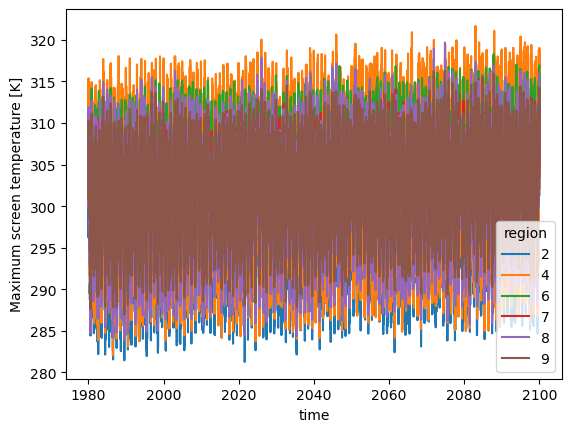

In [9]:
da_summary[f"{var}_mean"].plot.line(x="time")

<Axes: xlabel='time', ylabel='tmaxscr_mean'>

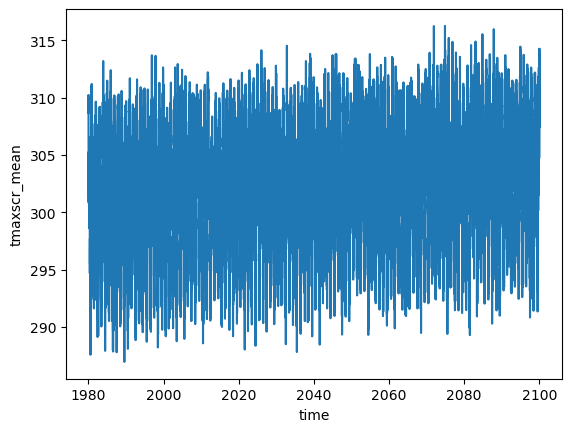

In [10]:
# or, use seaborn to plot the range of values from multiple models
da= da_summary[f"{var}_mean"].sel(region=9).to_dataframe()
sns.lineplot(data=da, x="time", y= f"{var}_mean",  errorbar=("pi", 100) )

# example for GWLs
use open_mfdataset to preprocess files to enable concatenation. 

apply acs_regional_stats on concatenated data with multiple models.

In [11]:
# choose a list of files to open
# this list of files will be combined to form a dataset with model, time, lat, and lon dimensions
# we will calculate regional averages and then calculate timeseries for a selected region for each model

var = "TXx"
gwl="GWL12"
path = f"/g/data/ia39/ncra/heat/data/{var}/raw/individual_models/GWL-timeseries"

filelist = glob(f"{path}/{var}_*_{gwl}.nc")
filelist

['/g/data/ia39/ncra/heat/data/TXx/raw/individual_models/GWL-timeseries/TXx_AGCD-05i_CNRM-ESM2-1_ssp370_r1i1p1f2_CSIRO_CCAM-v2203-SN_v1-r1_GWL12.nc',
 '/g/data/ia39/ncra/heat/data/TXx/raw/individual_models/GWL-timeseries/TXx_AGCD-05i_ACCESS-ESM1-5_ssp370_r6i1p1f1_CSIRO_CCAM-v2203-SN_v1-r1_GWL12.nc',
 '/g/data/ia39/ncra/heat/data/TXx/raw/individual_models/GWL-timeseries/TXx_AGCD-05i_EC-Earth3_ssp370_r1i1p1f1_BOM_BARPA-R_v1-r1_GWL12.nc',
 '/g/data/ia39/ncra/heat/data/TXx/raw/individual_models/GWL-timeseries/TXx_AGCD-05i_ACCESS-ESM1-5_ssp370_r6i1p1f1_BOM_BARPA-R_v1-r1_GWL12.nc',
 '/g/data/ia39/ncra/heat/data/TXx/raw/individual_models/GWL-timeseries/TXx_AGCD-05i_CMCC-ESM2_ssp370_r1i1p1f1_CSIRO_CCAM-v2203-SN_v1-r1_GWL12.nc',
 '/g/data/ia39/ncra/heat/data/TXx/raw/individual_models/GWL-timeseries/TXx_AGCD-05i_EC-Earth3_ssp370_r1i1p1f1_CSIRO_CCAM-v2203-SN_v1-r1_GWL12.nc',
 '/g/data/ia39/ncra/heat/data/TXx/raw/individual_models/GWL-timeseries/TXx_AGCD-05i_CESM2_ssp370_r11i1p1f1_BOM_BARPA-R_v1-r1

In [12]:
%%time
# open the list of files into one xarray dataset
def _preprocess(ds):
    # mask where precipitation data is unreliable
    return ds.convert_calendar("standard")

ds = xr.open_mfdataset(filelist, 
                       preprocess= lambda ds: _preprocess(ds),
                       use_cftime=True,
                       combine="nested",
                       concat_dim="model",
                       combine_attrs= "drop_conflicts").load()
ds

CPU times: user 1.81 s, sys: 1.87 s, total: 3.68 s
Wall time: 1.95 s


<xarray.Dataset> Size: 1GB
Dimensions:  (model: 13, time: 45, lat: 691, lon: 886)
Coordinates:
  * lat      (lat) float64 6kB -44.5 -44.45 -44.4 -44.35 ... -10.1 -10.05 -10.0
  * lon      (lon) float64 7kB 112.0 112.0 112.1 112.2 ... 156.2 156.2 156.2
  * time     (time) datetime64[ns] 360B 2004-01-01 2005-01-01 ... 2048-01-01
Dimensions without coordinates: model
Data variables:
    TXx      (model, time, lat, lon) float32 1GB nan nan nan ... 31.64 31.64
Attributes:
    pathway:                 ssp370
    GWL:                     GWL 1.2 degC
    bias_correction_method:  raw
    contact:                 Mitchell Black (mitchell.black@bom.gov.au)
    code:                    https://github.com/AusClimateService/hazards-heat

In [13]:
%%time
# use acs_regional_stats to calculate the regional mean for each model and month
da_summary =  acs_regional_stats(ds=ds, var=var, mask = mask, dims = ("lat", "lon",), how = ["mean"],)
da_summary

CPU times: user 7.38 s, sys: 3.07 s, total: 10.5 s
Wall time: 10.4 s


<xarray.Dataset> Size: 49kB
Dimensions:   (time: 45, region: 10, model: 13)
Coordinates:
  * time      (time) datetime64[ns] 360B 2004-01-01 2005-01-01 ... 2048-01-01
    abbrevs   (region) <U8 320B 'WANorth' 'WASouth' 'NSW' ... 'QLDSouth' 'AUS'
    names     (region) <U48 2kB 'Western Australia North' ... 'Australia'
  * region    (region) int64 80B 0 1 2 3 4 5 6 7 8 9
Dimensions without coordinates: model
Data variables:
    TXx_mean  (model, time, region) float64 47kB nan nan nan ... 45.11 44.03
Attributes:
    long_name:      annual maximum daily maximum temperature
    standard_name:  air_temperature
    units:          degC
    regrid_method:  bilinear
    cell_methods:   time: maximum (interval: 1Y)

In [14]:
%%time
# use acs_regiona_stats to calculate the regional mean for each model and month
da_summary =  acs_regional_stats(ds=ds, var=var, mask = mask, dims = ("lat", "lon",), how = ["mean"], chunks=4,)
da_summary

CPU times: user 6.76 s, sys: 2.96 s, total: 9.72 s
Wall time: 9.73 s


<xarray.Dataset> Size: 49kB
Dimensions:   (model: 13, time: 45, region: 10)
Coordinates:
  * time      (time) datetime64[ns] 360B 2004-01-01 2005-01-01 ... 2048-01-01
    abbrevs   (region) <U8 320B 'WANorth' 'WASouth' 'NSW' ... 'QLDSouth' 'AUS'
    names     (region) <U48 2kB 'Western Australia North' ... 'Australia'
  * region    (region) int64 80B 0 1 2 3 4 5 6 7 8 9
Dimensions without coordinates: model
Data variables:
    TXx_mean  (model, time, region) float64 47kB nan nan nan ... 45.11 44.03
Attributes:
    long_name:      annual maximum daily maximum temperature
    standard_name:  air_temperature
    units:          degC
    regrid_method:  bilinear
    cell_methods:   time: maximum (interval: 1Y)

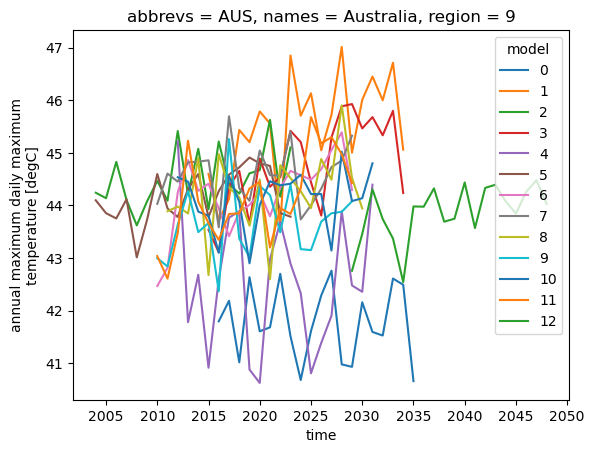

In [15]:
# select the region you like and plot the regional average for each month of each model
da_summary[f"{var}_mean"].sel(region=9).plot.line(x="time");

<Axes: xlabel='time', ylabel='TXx_mean'>

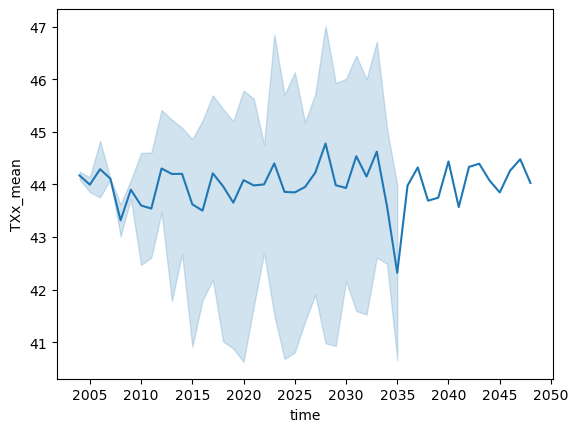

In [16]:
# or, use seaborn to plot the range of values from multiple models
da= da_summary[f"{var}_mean"].sel(region=9).to_dataframe()
sns.lineplot(data=da, x="time", y= f"{var}_mean",  errorbar=("pi", 100) )

# Smaller regions eg LGAs
A larger number of regions is more memory intensive. Here is an example of many LGA regions, instead of the ~10 NCRA regions.

In [5]:
file = '/g/data/py18/BARPA/output/CMIP6/DD/AUS-15/BOM/ACCESS-CM2/ssp370/r4i1p1f1/BARPA-R/v1-r1/day/tas/latest/tas_AUS-15_ACCESS-CM2_ssp370_r4i1p1f1_BOM_BARPA-R_v1-r1_day_201501-201512.nc'
ds = xr.open_dataset(file)

regions = get_regions(["aus_local_gov"])
regions

<regionmask.Regions 'aus_local_gov'>
overlap:  True

Regions:
  0 10050                      Albury
  1 10180                    Armidale
  2 10250                     Ballina
  3 10300                   Balranald
  4 10470                    Bathurst
 ..   ...                         ...
542 74660                 West Arnhem
543 74680                   West Daly
544 79399           Unincorporated NT
545 89399          Unincorporated ACT
546 99399 Unincorp. Other Territories

[547 regions]

In [10]:
%%time

file = '/g/data/py18/BARPA/output/CMIP6/DD/AUS-15/BOM/ACCESS-CM2/ssp370/r4i1p1f1/BARPA-R/v1-r1/day/tas/latest/tas_AUS-15_ACCESS-CM2_ssp370_r4i1p1f1_BOM_BARPA-R_v1-r1_day_201501-201512.nc'
ds = xr.open_dataset(file)

regions = get_regions(["aus_local_gov"])

# select only the LGAs you are interested in
var="tas"

city_list = ["Melbourne", "Sydney", "Darwin", "Perth", "Hobart", "Adelaide", "Brisbane"]

# only calculate the mask for the selected LGAs
mask = regions[regions.map_keys(city_list)].mask_3D_frac_approx(ds)

da_summary = acs_regional_stats(ds=ds,
                                var=var,
                                mask = mask.where(mask.names.isin(city_list), drop=True), 
                                dims = ("lat", "lon",), 
                                how = ["mean"],
                                outfile="out.csv",
                               chunks=1)
# da_summary

CPU times: user 11 s, sys: 2.89 s, total: 13.9 s
Wall time: 14.1 s


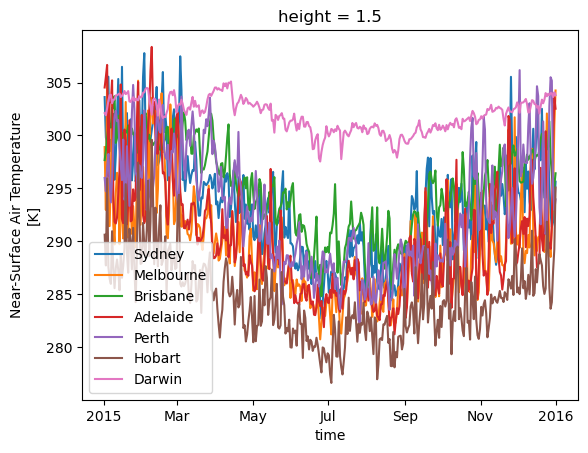

In [11]:
da_summary[f"{var}_mean"].plot(x="time", hue="region")
plt.legend(da_summary.names.values)

# Managing memory for all (or many) LGAs

In [20]:
file = '/g/data/py18/BARPA/output/CMIP6/DD/AUS-15/BOM/ACCESS-CM2/ssp370/r4i1p1f1/BARPA-R/v1-r1/day/tas/latest/tas_AUS-15_ACCESS-CM2_ssp370_r4i1p1f1_BOM_BARPA-R_v1-r1_day_201501-201512.nc'
ds = xr.open_dataset(file)

regions = get_regions(["aus_local_gov"])
regions

<regionmask.Regions 'aus_local_gov'>
overlap:  True

Regions:
  0 10050                      Albury
  1 10180                    Armidale
  2 10250                     Ballina
  3 10300                   Balranald
  4 10470                    Bathurst
 ..   ...                         ...
542 74660                 West Arnhem
543 74680                   West Daly
544 79399           Unincorporated NT
545 89399          Unincorporated ACT
546 99399 Unincorp. Other Territories

[547 regions]

In [21]:
%%time
# building this mask is very memory intensive ~50GB and a few minutes
mask = regions.mask_3D_frac_approx(ds)

CPU times: user 1min 42s, sys: 2min 30s, total: 4min 12s
Wall time: 4min 13s


In [22]:
%%time
# select only the LGAs you are interested in
var="tas"

da_summary = acs_regional_stats(ds=ds,
                                var=var,
                                mask = mask, 
                                dims = ("lat", "lon",), 
                                how = ["mean"],
                                outfile="out.csv",
                               chunks=1)
da_summary

CPU times: user 8min 38s, sys: 4min 20s, total: 12min 59s
Wall time: 12min 59s


<xarray.Dataset> Size: 2MB
Dimensions:   (time: 365, region: 545)
Coordinates:
  * time      (time) datetime64[ns] 3kB 2015-01-01T12:00:00 ... 2015-12-31T12...
    height    float64 8B 1.5
  * region    (region) int64 4kB 0 1 2 3 4 5 6 7 ... 540 541 542 543 544 545 546
    abbrevs   (region) <U5 11kB '10050' '10180' '10250' ... '89399' '99399'
    names     (region) <U37 81kB 'Albury' ... 'Unincorp. Other Territories'
Data variables:
    tas_mean  (time, region) float64 2MB 303.1 297.2 298.4 ... 302.8 291.7 294.8
Attributes:
    long_name:      Near-Surface Air Temperature
    standard_name:  air_temperature
    units:          K
    cell_methods:   time: point (interval: 1H) time: mean (interval: 1D)
    grid_mapping:   crs

# From original BARPA data 
Daily data from 2015 to 2100.

~15km resolution

apply acs_regional_stats inside open_mfdataset as part of the preprocessor. This is very effective at managing memory. 

It is quite slow because there is a lot of data!

In [28]:
# choose a list of files to open
# this list of files will be combined to form a dataset with model, time, lat, and lon dimensions
# we will calculate regional averages and then calculate timeseries for a selected region for each model


path = f"/g/data/py18/BARPA/output/CMIP6/DD/AUS-15/BOM/ACCESS-CM2/ssp370/r4i1p1f1/BARPA-R/v1-r1/day/tas/latest"

filelist = sorted(glob(f"{path}/*.nc"))
filelist

['/g/data/py18/BARPA/output/CMIP6/DD/AUS-15/BOM/ACCESS-CM2/ssp370/r4i1p1f1/BARPA-R/v1-r1/day/tas/latest/tas_AUS-15_ACCESS-CM2_ssp370_r4i1p1f1_BOM_BARPA-R_v1-r1_day_201501-201512.nc',
 '/g/data/py18/BARPA/output/CMIP6/DD/AUS-15/BOM/ACCESS-CM2/ssp370/r4i1p1f1/BARPA-R/v1-r1/day/tas/latest/tas_AUS-15_ACCESS-CM2_ssp370_r4i1p1f1_BOM_BARPA-R_v1-r1_day_201601-201612.nc',
 '/g/data/py18/BARPA/output/CMIP6/DD/AUS-15/BOM/ACCESS-CM2/ssp370/r4i1p1f1/BARPA-R/v1-r1/day/tas/latest/tas_AUS-15_ACCESS-CM2_ssp370_r4i1p1f1_BOM_BARPA-R_v1-r1_day_201701-201712.nc',
 '/g/data/py18/BARPA/output/CMIP6/DD/AUS-15/BOM/ACCESS-CM2/ssp370/r4i1p1f1/BARPA-R/v1-r1/day/tas/latest/tas_AUS-15_ACCESS-CM2_ssp370_r4i1p1f1_BOM_BARPA-R_v1-r1_day_201801-201812.nc',
 '/g/data/py18/BARPA/output/CMIP6/DD/AUS-15/BOM/ACCESS-CM2/ssp370/r4i1p1f1/BARPA-R/v1-r1/day/tas/latest/tas_AUS-15_ACCESS-CM2_ssp370_r4i1p1f1_BOM_BARPA-R_v1-r1_day_201901-201912.nc',
 '/g/data/py18/BARPA/output/CMIP6/DD/AUS-15/BOM/ACCESS-CM2/ssp370/r4i1p1f1/BARPA-R/v1

In [29]:
xr.open_dataset(filelist[0])

<xarray.Dataset> Size: 989MB
Dimensions:    (time: 365, lat: 436, lon: 777, bnds: 2)
Coordinates:
  * time       (time) datetime64[ns] 3kB 2015-01-01T12:00:00 ... 2015-12-31T1...
  * lat        (lat) float64 3kB -53.58 -53.42 -53.27 ... 13.32 13.48 13.63
  * lon        (lon) float64 6kB 88.04 88.19 88.34 88.5 ... 207.6 207.8 207.9
    height     float64 8B ...
Dimensions without coordinates: bnds
Data variables:
    tas        (time, lat, lon) float64 989MB ...
    time_bnds  (time, bnds) datetime64[ns] 6kB ...
    crs        int32 4B ...
Attributes: (12/61)
    axiom_version:             0.1.0
    axiom_schema:              cordex-1D.json
    axiom_schemas_version:     0.1.0
    productive_version:        dcb907f
    Conventions:               CF-1.11, ACDD-1.3
    title:                     Bureau of Meteorology Atmospheric Regional Pro...
    ...                        ...
    date_metadata_modified:    2024-08-02T08:00:56Z
    geospatial_lat_min:        -53.5755
    geospatial_lat_max:        13.632
    geospatial_lon_min:        88.0355
    geospatial_lon_max:        207.9275
    history:                   Sun Jun 30 10:15:58 2024: /g/data/access/ngm/m...

In [30]:
# these files are on a different lat lon grid so we need to make a custom mask for this data
ds= xr.open_dataset(filelist[0])

regions = get_regions(["ncra_regions", "australia"])
mask = regions.mask_3D_frac_approx(ds)

In [31]:
%%time
# open the list of files into one xarray dataset
def _preprocess(ds):
    # open file, drop redundant variables, define chunks sizes (make sure lat lon are not split or regional averages)
    data = ds.drop_vars(["height", "time_bnds", "crs"]).chunk({"lat":-1, "lon":-1})
    # Calculate region mean per file
    da_summary = acs_regional_stats(ds=data, var="tas", mask =mask, dims = ("lat", "lon",), how = ["mean"],)
    return da_summary

# preprocess does the area averaging and open_mfdataset cleverly concatenates the data
ds = xr.open_mfdataset(filelist, 
                       preprocess= lambda ds: _preprocess(ds),
                       use_cftime=True,).load()

ds

CPU times: user 11min 49s, sys: 3min 12s, total: 15min 2s
Wall time: 14min 51s


<xarray.Dataset> Size: 3MB
Dimensions:   (time: 31411, region: 10)
Coordinates:
  * time      (time) object 251kB 2015-01-01 12:00:00 ... 2100-12-31 12:00:00
    height    float64 8B 1.5
  * region    (region) int64 80B 0 1 2 3 4 5 6 7 8 9
    abbrevs   (region) <U8 320B 'WANorth' 'WASouth' 'NSW' ... 'QLDSouth' 'AUS'
    names     (region) <U48 2kB 'Western Australia North' ... 'Australia'
Data variables:
    tas_mean  (time, region) float64 3MB 304.8 302.6 305.4 ... 308.0 309.0 305.7
Attributes:
    long_name:      Near-Surface Air Temperature
    standard_name:  air_temperature
    units:          K
    cell_methods:   time: point (interval: 1H) time: mean (interval: 1D)
    grid_mapping:   crs

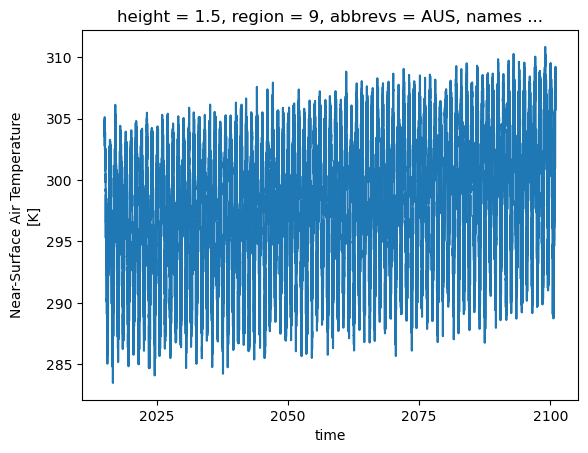

In [32]:
var="tas"
ds[f"{var}_mean"].sel(region=9).plot.line(x="time");